In [323]:
import networkx as nx

In [324]:
def modularity_optimisation(nodes, edges, communities, edges_of_node, w, k_i, m):

    best_community_list = [[node] for node in nodes]
    sigma_in = [0 for node in nodes]
    sigma_tot = [k_i[node] for node in nodes]
    for edge in edges:
        if edge[0][0] == edge[0][1]:
            sigma_in[edge[0][0]] += edge[1]
            sigma_in[edge[0][1]] += edge[1]
    
    while 1:
        
        community_check = 0
        for node in nodes:
            comm = communities[node]
            best_community = comm
            best_gain = 0

            if node not in best_community_list[comm]:
                continue

            best_community_list[comm].remove(node)
            best_weight = 0

            for e in edges_of_node[node]:
                
                if e[0][0] == e[0][1]:
                    continue
                if e[0][0] == node and communities[e[0][1]] == comm or e[0][1] == node and communities[e[0][0]] == comm:
                    best_weight += e[1]

            sigma_in[comm] -= 2 * (best_weight + w[node])
            sigma_tot[comm] -= k_i[node]
            communities[node] = -1
            lcommunities = {}
            
            neighborsu = []
            neighborsv = []
            
            for edge in edges_of_node[node]:

                if edge[0][0] == node:
                    neighborsu.append(edge[0][1])
                if edge[0][1] == node:
                    neighborsv.append(edge[0][0])
            
            neighbors = neighborsu + neighborsv

            for neighbor in neighbors:
               
                community = communities[neighbor]
                
                if community in lcommunities:
                    continue
                lcommunities[community] = 1
                
                edge_weights = 0
                for e in edges_of_node[node]:
                    if e[0][0] == e[0][1]:
                        continue
                    if e[0][0] == node and communities[e[0][1]] == community or e[0][1] == node and communities[e[0][0]] == community:
                        edge_weights += e[1]

                delta_modularity = 2 * edge_weights - sigma_tot[community] * k_i[node] / m
                
                if delta_modularity > best_gain:
                    best_community = community
                    best_gain = delta_modularity
                    best_weight = edge_weights
                    
            best_community_list[best_community].append(node)
            communities[node] = best_community
            
            sigma_in[best_community] += 2 * (best_weight + w[node])
            sigma_tot[best_community] += k_i[node]
            
            if comm != best_community:
                community_check = 1
                
        if not community_check:
            break

    return best_community_list, communities, sigma_in, sigma_tot

In [325]:
def community_aggregation(nodes, edges, community_list, k_i, edges_of_node, communities, w):

    new_nodes = [i for i in range(len(community_list))]

    lcommunities = []
    d = {}
    i = 0
    for comm in communities:
        if comm in d:
            lcommunities.append(d[comm])
        else:
            d[comm] = i
            lcommunities.append(i)
            i += 1
    communities = lcommunities

    n_edges = {}
    for e in edges:
        ci = communities[e[0][0]]
        cj = communities[e[0][1]]
        if (ci, cj) in n_edges:
            n_edges[(ci, cj)] += e[1]
        else:
            n_edges[(ci, cj)] = e[1]

    new_edges = [(u, v) for u, v in n_edges.items()]

    k_i = [0 for n in new_nodes]
    edges_of_node = {}
    w = [0 for n in new_nodes]
    for e in new_edges:
        k_i[e[0][0]] += e[1]
        k_i[e[0][1]] += e[1]
        if e[0][0] == e[0][1]:
            w[e[0][0]] += e[1]
        if e[0][0] not in edges_of_node:
            edges_of_node[e[0][0]] = [e]
        else:
            edges_of_node[e[0][0]].append(e)
        if e[0][1] not in edges_of_node:
            edges_of_node[e[0][1]] = [e]
        elif e[0][0] != e[0][1]:
            edges_of_node[e[0][1]].append(e)
    
    communities = [n for n in new_nodes]

    return (new_nodes, new_edges, k_i, edges_of_node, w, communities)


In [326]:
def calc_wts(nodes, edges):

    m = 0
    k_i = [0 for n in nodes]
    for e in edges:
            m += e[1]
            k_i[e[0][0]] += e[1]
            k_i[e[0][1]] += e[1] # there's no self-loop initially
    return m, k_i

def get_edges_of_node(edges):
    edges_of_node = {}
    for e in edges:
        if e[0][0] not in edges_of_node:
            edges_of_node[e[0][0]] = [e]
        else:
            edges_of_node[e[0][0]].append(e)
        if e[0][1] not in edges_of_node:
            edges_of_node[e[0][1]] = [e]
        elif e[0][0] != e[0][1]:
            edges_of_node[e[0][1]].append(e)
    return edges_of_node

def add_weight_to_edge(edges):
    edge_list = []
    unit_weight = 1
    for e in edges:
        edge_list.append(((e[0], e[1]), unit_weight))
    return edge_list


In [327]:
def zachary():
    
    G = nx.karate_club_graph()
    initial_vertices = list(G.nodes)
    initial_edges = add_weight_to_edge(list(G.edges))

    m, k_i = calc_wts(initial_vertices, initial_edges)
    w = [0 for n in initial_vertices]
    communities = [n for n in initial_vertices]
    edges_of_node = get_edges_of_node(initial_edges)
    full_community_list = []

    return G, louvains_method(initial_vertices, initial_edges, m, k_i, w, edges_of_node, communities, full_community_list)
    
def plantedl():

    G = nx.planted_partition_graph(5, 100, 0.5, 0.1, seed=42)
#     G = nx.planted_partition_graph(5, 200, 0.8, 0.1, seed=42)
#     G = nx.planted_partition_graph(2, 200, 0.6, 0.3, seed=42)
    initial_vertices = list(G.nodes)
    initial_edges = add_weight_to_edge(list(G.edges))

    m, k_i = calc_wts(initial_vertices, initial_edges)
    w = [0 for n in initial_vertices]
    communities = [n for n in initial_vertices]
    edges_of_node = get_edges_of_node(initial_edges)
    full_community_list = []

    return G, louvains_method(initial_vertices, initial_edges, m, k_i, w, edges_of_node, communities, full_community_list)
    

In [328]:
def visualize_graph(G, pos, labels_dict=None, colors=None, node_size=100, edge_alpha=0.1, labels=False):
    """
    Visualizes graph with clusters as different colors
    """

    if labels_dict is not None and colors is not None:
        for k, v in labels_dict.items():
            # nodes
            nx.draw_networkx_nodes(G, 
                pos,
                nodelist=v,
                node_color=colors[k],
                node_size=node_size
            )
    else:
        nx.draw_networkx_nodes(G, pos, node_size=node_size) 
        
    if labels:
        nx.draw_networkx_labels(G, pos)

    nx.draw_networkx_edges(G, pos, width=1.0, alpha=edge_alpha)

In [329]:
result = plantedl()
# print(result)
G = result[0]
final_partition = result[1][0]

final_modularity = result[1][1]
# print(final_modularity)

pos = nx.spring_layout(G)

labels_dict = {i: final_partition[i] for i in range(len(final_partition))}
print(labels_dict.keys())

COLORS = \
    ["tab:blue", "tab:orange", "tab:green", 
     "tab:red", "tab:purple", "tab:brown", 
     "tab:pink", "tab:gray", "tab:olive", 
     "tab:cyan"]



dict_keys([0, 1, 2, 3, 4])


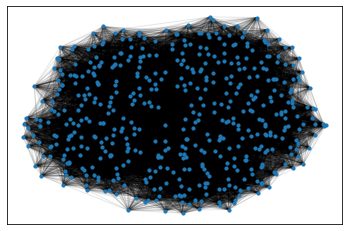

In [330]:
visualize_graph(G, pos, labels_dict=None, colors=COLORS, node_size=10)

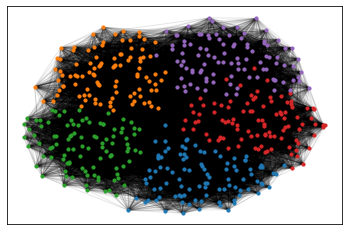

In [331]:
visualize_graph(G, pos, labels_dict=labels_dict, colors=COLORS, node_size=10)